<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#MNIST-Dataset-Download-and-normalization" data-toc-modified-id="MNIST-Dataset-Download-and-normalization-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>MNIST Dataset Download and normalization</a></span></li></ul></li><li><span><a href="#Networks" data-toc-modified-id="Networks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Networks</a></span><ul class="toc-item"><li><span><a href="#Discriminator" data-toc-modified-id="Discriminator-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Discriminator</a></span></li><li><span><a href="#Generator" data-toc-modified-id="Generator-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Generator</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li></ul></div>

## Initialization

In [1]:
import numpy as np
import os
import sys
import torch
from torch import nn, optim
from torch.autograd.variable import Variable as V
from torchvision import datasets, transforms, models, transforms, utils
from matplotlib import pyplot as plt
from matplotlib import gridspec

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(sys.version) # Python version
print(torch.cuda.device(0))
torch.cuda.get_device_name(0)

3.6.7 |Anaconda custom (64-bit)| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]


'GeForce GTX 1060'

In [3]:
seed=30
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  30


### MNIST Dataset Download and normalization

In [4]:
def get_mnist():
    transform_normalize_tensor=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.50,0.50,0.50),(0.50,0.50,0.50))
        
    ])
    return datasets.MNIST(root='./mnist_dataset', train=True, transform=transform_normalize_tensor, download=True)

In [5]:
# Dataset Loader
mnist_dataset=get_mnist()
mnist_dataloader=torch.utils.data.DataLoader(dataset=mnist_dataset, batch_size=128, shuffle=True, drop_last=False)

## Networks

### Discriminator

In [6]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        n_features= 784 # Flattened 28*28 image
        n_out=1 # Bool Real or Generated image
        
        self.hidden0=nn.Sequential(
            nn.Linear(n_features,1024),
            nn.SELU()
        )
        self.hidden1=nn.Sequential(
            nn.Linear(1024,512),
            nn.SELU(),
            nn.Dropout(0.25)
        )
        self.hidden2=nn.Sequential(
            nn.Linear(512,128),
            nn.SELU(),
            nn.Dropout(0.25)
        )
        self.out=nn.Sequential(
            nn.Linear(128,n_out),
            nn.Sigmoid()
        )
        
        self.optimizer=optim.Adam(self.parameters(), lr=0.00002)
    
    def forward(self, x):
        x=self.hidden0(x)
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.out(x)
        return x
    
    def train(self, real_data, false_data):
        self.optimizer.zero_grad() # Zero/ Reset all gradients
        loss=nn.BCELoss() # Binary Cross-Entropy Loss
        
        # Real data training
        prediction_real=self(real_data) # Prediction
        real_ones_data=V(torch.ones(real_data.size(0),1)).cuda() # Label ones
        error_real=loss(prediction_real,real_ones_data)
        error_real.backward()
        
        # Fake data training
        prediction_false=self(false_data) # Prediction on generated data
        real_zeros_data=V(torch.zeros(false_data.size(0),1)).cuda() # Label zeros
        error_false=loss(prediction_false,real_zeros_data)
        error_false.backward() # Backprop error
        
        self.optimizer.step() # Update weights of Adam
        
        return error_real+error_false,prediction_real,prediction_false # Error, predictions

### Generator

In [7]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        n_features=100 # Latent variable vector size
        n_out=784 # 28*28 input image
                
        self.hidden0=nn.Sequential(
            nn.Linear(n_features,256),
            nn.SELU()
        )
        self.hidden1=nn.Sequential(
            nn.Linear(256,512),
            nn.SELU(),
            nn.Dropout(0.25)
        )
        self.hidden2=nn.Sequential(
            nn.Linear(512,1024),
            nn.SELU(),
            nn.Dropout(0.25)
        )
        self.out=nn.Sequential(
            nn.Linear(1024,n_out),
            nn.Tanh()
        )
        
        self.optimizer=optim.Adam(self.parameters(), lr=0.00002)
    
    def forward(self, x):
        x=self.hidden0(x)
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.out(x)
        return x
    
    def train(self, discriminator, false_data):
        self.optimizer.zero_grad() # Zero/ Reset all gradients
        loss=nn.BCELoss() # Binary Cross-Entropy Loss
        
        prediction=discriminator(false_data)
        real_ones_data=V(torch.ones(false_data.size(0),1)).cuda()
        error=loss(prediction, real_ones_data)
        error.backward() # Backprop error
        
        self.optimizer.step() # Update weights of Adam
    
        return error       

## Training 

In [8]:
def sample_noise(sample_size, latent_vec_size):
    return V(torch.randn(sample_size, latent_vec_size)).cuda()



-----Discriminator-----
Discriminator(
  (hidden0): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): SELU()
  )
  (hidden1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.25)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): SELU()
    (2): Dropout(p=0.25)
  )
  (out): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
) 

-----Generator-----
Generator(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): SELU()
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.25)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): SELU()
    (2): Dropout(p=0.25)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias

/home/nsrishankar/miniconda3/envs/custom_dl_env/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/nsrishankar/miniconda3/envs/custom_dl_env/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Epoch 1, Batch 128

	Discriminator Error: 0.46580979228019714, Generator Error: 4.404162406921387

Epoch 1, Batch 256

	Discriminator Error: 0.13060221076011658, Generator Error: 4.390164375305176

Epoch 1, Batch 384

	Discriminator Error: 0.04077690467238426, Generator Error: 3.752420663833618

Epoch 2, Batch 0

	Discriminator Error: 0.06876341253519058, Generator Error: 3.6199445724487305

Epoch 2, Batch 128

	Discriminator Error: 0.07113422453403473, Generator Error: 4.04784631729126

Epoch 2, Batch 256

	Discriminator Error: 0.08809156715869904, Generator Error: 3.9567856788635254

Epoch 2, Batch 384

	Discriminator Error: 0.11524602025747299, Generator Error: 3.8121414184570312

Epoch 3, Batch 0

	Discriminator Error: 0.17178389430046082, Generator Error: 4.188081741333008

Epoch 3, Batch 128

	Discriminator Error: 0.14637675881385803, Generator Error: 4.515932083129883

Epoch 3, Batch 256

	Discriminator Error: 0.14245958626270294, Generator Error: 4.883615970611572

Epoch 3, Ba


Epoch 21, Batch 384

	Discriminator Error: 0.027288585901260376, Generator Error: 6.932239532470703

Epoch 22, Batch 0

	Discriminator Error: 0.011250442825257778, Generator Error: 8.609787940979004

Epoch 22, Batch 128

	Discriminator Error: 0.02758108265697956, Generator Error: 5.1042914390563965

Epoch 22, Batch 256

	Discriminator Error: 0.007413554470986128, Generator Error: 7.568779945373535

Epoch 22, Batch 384

	Discriminator Error: 0.03364144638180733, Generator Error: 7.0550336837768555

Epoch 23, Batch 0

	Discriminator Error: 0.08624250441789627, Generator Error: 8.293156623840332

Epoch 23, Batch 128

	Discriminator Error: 0.012143555097281933, Generator Error: 8.2662353515625

Epoch 23, Batch 256

	Discriminator Error: 0.018135135993361473, Generator Error: 7.056455612182617

Epoch 23, Batch 384

	Discriminator Error: 0.035719506442546844, Generator Error: 7.5301361083984375

Epoch 24, Batch 0

	Discriminator Error: 0.004191746469587088, Generator Error: 9.39035701751709


Epoch 42, Batch 0

	Discriminator Error: 0.020271604880690575, Generator Error: 9.571220397949219

Epoch 42, Batch 128

	Discriminator Error: 0.00036940176505595446, Generator Error: 11.679242134094238

Epoch 42, Batch 256

	Discriminator Error: 0.0005195699050091207, Generator Error: 14.727023124694824

Epoch 42, Batch 384

	Discriminator Error: 0.00034654198680073023, Generator Error: 11.380607604980469

Epoch 43, Batch 0

	Discriminator Error: 8.732527203392237e-05, Generator Error: 11.936238288879395

Epoch 43, Batch 128

	Discriminator Error: 0.0008051411714404821, Generator Error: 10.068923950195312

Epoch 43, Batch 256

	Discriminator Error: 0.0003273281909059733, Generator Error: 11.436532020568848

Epoch 43, Batch 384

	Discriminator Error: 0.0012474579270929098, Generator Error: 10.657991409301758

Epoch 44, Batch 0

	Discriminator Error: 1.2176054042356554e-05, Generator Error: 13.45012092590332

Epoch 44, Batch 128

	Discriminator Error: 0.0025288385804742575, Generator Er


Epoch 62, Batch 128

	Discriminator Error: 0.044078294187784195, Generator Error: 10.090689659118652

Epoch 62, Batch 256

	Discriminator Error: 0.022516723722219467, Generator Error: 11.42311954498291

Epoch 62, Batch 384

	Discriminator Error: 0.0023740192409604788, Generator Error: 11.290056228637695

Epoch 63, Batch 0

	Discriminator Error: 0.0464772954583168, Generator Error: 12.210684776306152

Epoch 63, Batch 128

	Discriminator Error: 0.0004242499708198011, Generator Error: 11.6409273147583

Epoch 63, Batch 256

	Discriminator Error: 0.0013021741760894656, Generator Error: 10.587409019470215

Epoch 63, Batch 384

	Discriminator Error: 0.0006636889884248376, Generator Error: 13.018299102783203

Epoch 64, Batch 0

	Discriminator Error: 0.019205881282687187, Generator Error: 9.736528396606445

Epoch 64, Batch 128

	Discriminator Error: 0.0019712564535439014, Generator Error: 10.166069030761719

Epoch 64, Batch 256

	Discriminator Error: 0.03671998158097267, Generator Error: 10.02


Epoch 82, Batch 256

	Discriminator Error: 0.01957366056740284, Generator Error: 10.534497261047363

Epoch 82, Batch 384

	Discriminator Error: 0.044634077697992325, Generator Error: 15.595229148864746

Epoch 83, Batch 0

	Discriminator Error: 0.0029721325263381004, Generator Error: 17.135961532592773

Epoch 83, Batch 128

	Discriminator Error: 0.0047154612839221954, Generator Error: 12.456506729125977

Epoch 83, Batch 256

	Discriminator Error: 0.056459829211235046, Generator Error: 9.805696487426758

Epoch 83, Batch 384

	Discriminator Error: 0.0036859726533293724, Generator Error: 7.8123650550842285

Epoch 84, Batch 0

	Discriminator Error: 0.00261678290553391, Generator Error: 10.476279258728027

Epoch 84, Batch 128

	Discriminator Error: 0.009607912041246891, Generator Error: 12.03325366973877

Epoch 84, Batch 256

	Discriminator Error: 0.0019150496227666736, Generator Error: 12.658448219299316

Epoch 84, Batch 384

	Discriminator Error: 0.014635881409049034, Generator Error: 11.


Epoch 103, Batch 0

	Discriminator Error: 0.027104411274194717, Generator Error: 7.847055912017822

Epoch 103, Batch 128

	Discriminator Error: 0.049728624522686005, Generator Error: 6.401726722717285

Epoch 103, Batch 256

	Discriminator Error: 0.11856813728809357, Generator Error: 4.35225248336792

Epoch 103, Batch 384

	Discriminator Error: 0.04763718321919441, Generator Error: 7.875444412231445

Epoch 104, Batch 0

	Discriminator Error: 0.1090809777379036, Generator Error: 6.853721618652344

Epoch 104, Batch 128

	Discriminator Error: 0.09181977063417435, Generator Error: 7.56865119934082

Epoch 104, Batch 256

	Discriminator Error: 0.2826508581638336, Generator Error: 5.426389694213867

Epoch 104, Batch 384

	Discriminator Error: 0.060030799359083176, Generator Error: 5.885926246643066

Epoch 105, Batch 0

	Discriminator Error: 0.013321496546268463, Generator Error: 6.479367256164551

Epoch 105, Batch 128

	Discriminator Error: 0.021737484261393547, Generator Error: 6.14605283737


Epoch 123, Batch 128

	Discriminator Error: 0.10831736028194427, Generator Error: 6.905289649963379

Epoch 123, Batch 256

	Discriminator Error: 0.048212915658950806, Generator Error: 6.866114616394043

Epoch 123, Batch 384

	Discriminator Error: 0.038778405636548996, Generator Error: 7.354849815368652

Epoch 124, Batch 0

	Discriminator Error: 0.01717641018331051, Generator Error: 5.741151809692383

Epoch 124, Batch 128

	Discriminator Error: 0.0778236836194992, Generator Error: 8.377766609191895

Epoch 124, Batch 256

	Discriminator Error: 0.023466963320970535, Generator Error: 5.15001106262207

Epoch 124, Batch 384

	Discriminator Error: 0.025019308552145958, Generator Error: 6.952332496643066

Epoch 125, Batch 0

	Discriminator Error: 0.02917577140033245, Generator Error: 9.772768020629883

Epoch 125, Batch 128

	Discriminator Error: 0.03725511580705643, Generator Error: 6.8866472244262695

Epoch 125, Batch 256

	Discriminator Error: 0.07852347195148468, Generator Error: 6.6106824


Epoch 143, Batch 256

	Discriminator Error: 0.2901647984981537, Generator Error: 5.5830278396606445

Epoch 143, Batch 384

	Discriminator Error: 0.28566911816596985, Generator Error: 5.380520820617676

Epoch 144, Batch 0

	Discriminator Error: 0.2167525738477707, Generator Error: 3.205993413925171

Epoch 144, Batch 128

	Discriminator Error: 0.2578686773777008, Generator Error: 5.744072437286377

Epoch 144, Batch 256

	Discriminator Error: 0.12602464854717255, Generator Error: 4.357940196990967

Epoch 144, Batch 384

	Discriminator Error: 0.1300135850906372, Generator Error: 4.481621265411377

Epoch 145, Batch 0

	Discriminator Error: 0.1928170621395111, Generator Error: 4.759220123291016

Epoch 145, Batch 128

	Discriminator Error: 0.2345142364501953, Generator Error: 5.646737098693848

Epoch 145, Batch 256

	Discriminator Error: 0.2198866605758667, Generator Error: 5.146341800689697

Epoch 145, Batch 384

	Discriminator Error: 0.13463278114795685, Generator Error: 4.583550930023193



Epoch 163, Batch 384

	Discriminator Error: 0.33627864718437195, Generator Error: 5.407023906707764

Epoch 164, Batch 0

	Discriminator Error: 0.3168303966522217, Generator Error: 4.279568672180176

Epoch 164, Batch 128

	Discriminator Error: 0.23699791729450226, Generator Error: 4.775636672973633

Epoch 164, Batch 256

	Discriminator Error: 0.2976544499397278, Generator Error: 2.233020067214966

Epoch 164, Batch 384

	Discriminator Error: 0.2529066801071167, Generator Error: 5.301205158233643

Epoch 165, Batch 0

	Discriminator Error: 0.17304213345050812, Generator Error: 3.998178005218506

Epoch 165, Batch 128

	Discriminator Error: 0.22886642813682556, Generator Error: 4.415048599243164

Epoch 165, Batch 256

	Discriminator Error: 0.14383062720298767, Generator Error: 5.171982765197754

Epoch 165, Batch 384

	Discriminator Error: 0.3086472153663635, Generator Error: 3.0861289501190186

Epoch 166, Batch 0

	Discriminator Error: 0.2311970442533493, Generator Error: 3.5555307865142822


Epoch 184, Batch 0

	Discriminator Error: 0.39428025484085083, Generator Error: 3.480408191680908

Epoch 184, Batch 128

	Discriminator Error: 0.23563683032989502, Generator Error: 3.9358768463134766

Epoch 184, Batch 256

	Discriminator Error: 0.2758173942565918, Generator Error: 4.25812292098999

Epoch 184, Batch 384

	Discriminator Error: 0.295141339302063, Generator Error: 3.22729229927063

Epoch 185, Batch 0

	Discriminator Error: 0.22558069229125977, Generator Error: 3.943080186843872

Epoch 185, Batch 128

	Discriminator Error: 0.4051494002342224, Generator Error: 3.6812939643859863

Epoch 185, Batch 256

	Discriminator Error: 0.43132686614990234, Generator Error: 3.878178834915161

Epoch 185, Batch 384

	Discriminator Error: 0.2847854495048523, Generator Error: 4.050901412963867

Epoch 186, Batch 0

	Discriminator Error: 0.3422670066356659, Generator Error: 4.284060001373291

Epoch 186, Batch 128

	Discriminator Error: 0.39053693413734436, Generator Error: 3.8521368503570557



/home/nsrishankar/miniconda3/envs/custom_dl_env/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saved generated_images/Epoch_200.png

Epoch 201, Batch 0

	Discriminator Error: 0.36083176732063293, Generator Error: 4.211941719055176

Epoch 201, Batch 128

	Discriminator Error: 0.2616702616214752, Generator Error: 3.1850013732910156

Epoch 201, Batch 256

	Discriminator Error: 0.3479312062263489, Generator Error: 3.3542380332946777

Epoch 201, Batch 384

	Discriminator Error: 0.3595311641693115, Generator Error: 3.258235454559326

Epoch 202, Batch 0

	Discriminator Error: 0.2981726825237274, Generator Error: 1.93381929397583

Epoch 202, Batch 128

	Discriminator Error: 0.3703521490097046, Generator Error: 3.1473312377929688

Epoch 202, Batch 256

	Discriminator Error: 0.3364763557910919, Generator Error: 3.2142820358276367

Epoch 202, Batch 384

	Discriminator Error: 0.34041261672973633, Generator Error: 3.208739757537842

Epoch 203, Batch 0

	Discriminator Error: 0.5265142917633057, Generator Error: 2.7628140449523926

Epoch 203, Batch 128

	Discriminator Error: 0.4876937866210937


Epoch 221, Batch 128

	Discriminator Error: 0.298897385597229, Generator Error: 4.240364074707031

Epoch 221, Batch 256

	Discriminator Error: 0.4453964829444885, Generator Error: 3.887032985687256

Epoch 221, Batch 384

	Discriminator Error: 0.47735995054244995, Generator Error: 3.552457809448242

Epoch 222, Batch 0

	Discriminator Error: 0.5034784078598022, Generator Error: 2.8048367500305176

Epoch 222, Batch 128

	Discriminator Error: 0.4117010831832886, Generator Error: 3.054603338241577

Epoch 222, Batch 256

	Discriminator Error: 0.36275535821914673, Generator Error: 3.1745216846466064

Epoch 222, Batch 384

	Discriminator Error: 0.40727102756500244, Generator Error: 3.591945171356201

Epoch 223, Batch 0

	Discriminator Error: 0.6281318664550781, Generator Error: 3.1931443214416504

Epoch 223, Batch 128

	Discriminator Error: 0.42795291543006897, Generator Error: 3.0474538803100586

Epoch 223, Batch 256

	Discriminator Error: 0.37223678827285767, Generator Error: 3.542961597442


Epoch 241, Batch 256

	Discriminator Error: 0.4621220529079437, Generator Error: 2.9055943489074707

Epoch 241, Batch 384

	Discriminator Error: 0.5423356890678406, Generator Error: 3.478475332260132

Epoch 242, Batch 0

	Discriminator Error: 0.3830323815345764, Generator Error: 3.2847819328308105

Epoch 242, Batch 128

	Discriminator Error: 0.5115343332290649, Generator Error: 3.219386100769043

Epoch 242, Batch 256

	Discriminator Error: 0.5050728917121887, Generator Error: 2.8368096351623535

Epoch 242, Batch 384

	Discriminator Error: 0.4839444160461426, Generator Error: 2.6839609146118164

Epoch 243, Batch 0

	Discriminator Error: 0.3927604556083679, Generator Error: 3.3229031562805176

Epoch 243, Batch 128

	Discriminator Error: 0.4331163167953491, Generator Error: 3.9070756435394287

Epoch 243, Batch 256

	Discriminator Error: 0.4784749746322632, Generator Error: 3.1703667640686035

Epoch 243, Batch 384

	Discriminator Error: 0.454406201839447, Generator Error: 2.53512573242187


Epoch 262, Batch 0

	Discriminator Error: 0.4894959032535553, Generator Error: 2.475571870803833

Epoch 262, Batch 128

	Discriminator Error: 0.5486285090446472, Generator Error: 3.490773916244507

Epoch 262, Batch 256

	Discriminator Error: 0.365551233291626, Generator Error: 4.056634426116943

Epoch 262, Batch 384

	Discriminator Error: 0.46460431814193726, Generator Error: 2.82189679145813

Epoch 263, Batch 0

	Discriminator Error: 0.4214910864830017, Generator Error: 3.3522651195526123

Epoch 263, Batch 128

	Discriminator Error: 0.5276423692703247, Generator Error: 3.350836753845215

Epoch 263, Batch 256

	Discriminator Error: 0.5285975933074951, Generator Error: 2.4221622943878174

Epoch 263, Batch 384

	Discriminator Error: 0.5820484161376953, Generator Error: 3.299271821975708

Epoch 264, Batch 0

	Discriminator Error: 0.31067970395088196, Generator Error: 3.0103983879089355

Epoch 264, Batch 128

	Discriminator Error: 0.41920340061187744, Generator Error: 2.337615728378296

E


Epoch 282, Batch 256

	Discriminator Error: 0.3671044111251831, Generator Error: 3.5611824989318848

Epoch 282, Batch 384

	Discriminator Error: 0.38566285371780396, Generator Error: 3.244286060333252

Epoch 283, Batch 0

	Discriminator Error: 0.4758646786212921, Generator Error: 2.4548139572143555

Epoch 283, Batch 128

	Discriminator Error: 0.4822964072227478, Generator Error: 2.422351598739624

Epoch 283, Batch 256

	Discriminator Error: 0.8204801678657532, Generator Error: 2.584240436553955

Epoch 283, Batch 384

	Discriminator Error: 0.6130887269973755, Generator Error: 3.106100082397461

Epoch 284, Batch 0

	Discriminator Error: 0.5685684680938721, Generator Error: 2.453411102294922

Epoch 284, Batch 128

	Discriminator Error: 0.48480352759361267, Generator Error: 1.8081496953964233

Epoch 284, Batch 256

	Discriminator Error: 0.4295912981033325, Generator Error: 2.238527774810791

Epoch 284, Batch 384

	Discriminator Error: 0.5910571813583374, Generator Error: 3.395142078399658


Epoch 303, Batch 0

	Discriminator Error: 0.5216825008392334, Generator Error: 2.39825439453125

Epoch 303, Batch 128

	Discriminator Error: 0.5131475925445557, Generator Error: 3.7305378913879395

Epoch 303, Batch 256

	Discriminator Error: 0.5683467984199524, Generator Error: 3.2789483070373535

Epoch 303, Batch 384

	Discriminator Error: 0.38430848717689514, Generator Error: 2.669018268585205

Epoch 304, Batch 0

	Discriminator Error: 0.5631561279296875, Generator Error: 3.0385947227478027

Epoch 304, Batch 128

	Discriminator Error: 0.5385103225708008, Generator Error: 2.772322654724121

Epoch 304, Batch 256

	Discriminator Error: 0.5135101079940796, Generator Error: 2.7423925399780273

Epoch 304, Batch 384

	Discriminator Error: 0.5468752980232239, Generator Error: 3.155273675918579

Epoch 305, Batch 0

	Discriminator Error: 0.5466888546943665, Generator Error: 3.077984571456909

Epoch 305, Batch 128

	Discriminator Error: 0.43572497367858887, Generator Error: 3.3407557010650635



Epoch 323, Batch 256

	Discriminator Error: 0.5361807346343994, Generator Error: 2.709973096847534

Epoch 323, Batch 384

	Discriminator Error: 0.7041895389556885, Generator Error: 2.9162988662719727

Epoch 324, Batch 0

	Discriminator Error: 0.5965489149093628, Generator Error: 3.134202003479004

Epoch 324, Batch 128

	Discriminator Error: 0.5615392923355103, Generator Error: 2.9239001274108887

Epoch 324, Batch 256

	Discriminator Error: 0.5601869821548462, Generator Error: 3.1991124153137207

Epoch 324, Batch 384

	Discriminator Error: 0.553485631942749, Generator Error: 2.7929208278656006

Epoch 325, Batch 0

	Discriminator Error: 0.6178228259086609, Generator Error: 2.5827817916870117

Epoch 325, Batch 128

	Discriminator Error: 0.5638775825500488, Generator Error: 2.5175576210021973

Epoch 325, Batch 256

	Discriminator Error: 0.5607311129570007, Generator Error: 2.7333335876464844

Epoch 325, Batch 384

	Discriminator Error: 0.5402038097381592, Generator Error: 3.72420167922973


Epoch 344, Batch 0

	Discriminator Error: 0.5578436851501465, Generator Error: 3.1492812633514404

Epoch 344, Batch 128

	Discriminator Error: 0.6412423253059387, Generator Error: 2.6639513969421387

Epoch 344, Batch 256

	Discriminator Error: 0.48268264532089233, Generator Error: 2.082956075668335

Epoch 344, Batch 384

	Discriminator Error: 0.682100236415863, Generator Error: 2.515838146209717

Epoch 345, Batch 0

	Discriminator Error: 0.7816184759140015, Generator Error: 2.8644161224365234

Epoch 345, Batch 128

	Discriminator Error: 0.73602694272995, Generator Error: 2.9513494968414307

Epoch 345, Batch 256

	Discriminator Error: 0.5354964733123779, Generator Error: 2.5844058990478516

Epoch 345, Batch 384

	Discriminator Error: 0.8666641712188721, Generator Error: 3.7707386016845703

Epoch 346, Batch 0

	Discriminator Error: 0.6884279251098633, Generator Error: 2.2762529850006104

Epoch 346, Batch 128

	Discriminator Error: 0.5505779385566711, Generator Error: 2.163281202316284




Epoch 364, Batch 256

	Discriminator Error: 0.5049790143966675, Generator Error: 3.0618820190429688

Epoch 364, Batch 384

	Discriminator Error: 0.5282818675041199, Generator Error: 2.0507431030273438

Epoch 365, Batch 0

	Discriminator Error: 0.5635592341423035, Generator Error: 3.128063201904297

Epoch 365, Batch 128

	Discriminator Error: 0.5391902327537537, Generator Error: 2.4822998046875

Epoch 365, Batch 256

	Discriminator Error: 0.5315308570861816, Generator Error: 2.795438766479492

Epoch 365, Batch 384

	Discriminator Error: 0.6632466316223145, Generator Error: 2.5794942378997803

Epoch 366, Batch 0

	Discriminator Error: 0.45990321040153503, Generator Error: 1.8395798206329346

Epoch 366, Batch 128

	Discriminator Error: 0.5060355067253113, Generator Error: 3.1918375492095947

Epoch 366, Batch 256

	Discriminator Error: 0.5854603052139282, Generator Error: 3.0420124530792236

Epoch 366, Batch 384

	Discriminator Error: 0.6686238050460815, Generator Error: 2.342036724090576


Epoch 385, Batch 0

	Discriminator Error: 0.6616277694702148, Generator Error: 2.509554386138916

Epoch 385, Batch 128

	Discriminator Error: 0.6719542741775513, Generator Error: 2.5264317989349365

Epoch 385, Batch 256

	Discriminator Error: 0.6148542165756226, Generator Error: 2.623182773590088

Epoch 385, Batch 384

	Discriminator Error: 0.6219897270202637, Generator Error: 3.0287063121795654

Epoch 386, Batch 0

	Discriminator Error: 0.610510528087616, Generator Error: 2.8120219707489014

Epoch 386, Batch 128

	Discriminator Error: 0.544866681098938, Generator Error: 2.107912540435791

Epoch 386, Batch 256

	Discriminator Error: 0.5580053329467773, Generator Error: 1.6410256624221802

Epoch 386, Batch 384

	Discriminator Error: 0.5861817002296448, Generator Error: 2.4647886753082275

Epoch 387, Batch 0

	Discriminator Error: 0.6429517865180969, Generator Error: 2.938800096511841

Epoch 387, Batch 128

	Discriminator Error: 0.6194288730621338, Generator Error: 2.2395572662353516

E


Epoch 405, Batch 256

	Discriminator Error: 0.6541904807090759, Generator Error: 2.208141803741455

Epoch 405, Batch 384

	Discriminator Error: 0.6329388618469238, Generator Error: 2.23260760307312

Epoch 406, Batch 0

	Discriminator Error: 0.6308243274688721, Generator Error: 2.4961225986480713

Epoch 406, Batch 128

	Discriminator Error: 0.5691556930541992, Generator Error: 1.553584098815918

Epoch 406, Batch 256

	Discriminator Error: 0.6413991451263428, Generator Error: 1.6584115028381348

Epoch 406, Batch 384

	Discriminator Error: 0.6319377422332764, Generator Error: 3.2678277492523193

Epoch 407, Batch 0

	Discriminator Error: 0.6003458499908447, Generator Error: 2.0420336723327637

Epoch 407, Batch 128

	Discriminator Error: 0.7312122583389282, Generator Error: 2.4419970512390137

Epoch 407, Batch 256

	Discriminator Error: 0.6523423194885254, Generator Error: 2.443448781967163

Epoch 407, Batch 384

	Discriminator Error: 0.5263742804527283, Generator Error: 2.458277702331543



Epoch 426, Batch 0

	Discriminator Error: 0.6513141989707947, Generator Error: 2.27000093460083

Epoch 426, Batch 128

	Discriminator Error: 0.6436864733695984, Generator Error: 2.4579415321350098

Epoch 426, Batch 256

	Discriminator Error: 0.6854221820831299, Generator Error: 2.3998939990997314

Epoch 426, Batch 384

	Discriminator Error: 0.5867049694061279, Generator Error: 2.21087646484375

Epoch 427, Batch 0

	Discriminator Error: 0.8155035972595215, Generator Error: 2.4927995204925537

Epoch 427, Batch 128

	Discriminator Error: 0.6567679643630981, Generator Error: 1.771886944770813

Epoch 427, Batch 256

	Discriminator Error: 0.6992518305778503, Generator Error: 2.2729358673095703

Epoch 427, Batch 384

	Discriminator Error: 0.6424049735069275, Generator Error: 1.6919188499450684

Epoch 428, Batch 0

	Discriminator Error: 0.7011376023292542, Generator Error: 2.1634438037872314

Epoch 428, Batch 128

	Discriminator Error: 0.6169754266738892, Generator Error: 2.0253965854644775




Epoch 446, Batch 256

	Discriminator Error: 0.9019157290458679, Generator Error: 1.8843038082122803

Epoch 446, Batch 384

	Discriminator Error: 0.6696586608886719, Generator Error: 2.3344669342041016

Epoch 447, Batch 0

	Discriminator Error: 0.7608978152275085, Generator Error: 2.6282718181610107

Epoch 447, Batch 128

	Discriminator Error: 0.6302733421325684, Generator Error: 2.055025339126587

Epoch 447, Batch 256

	Discriminator Error: 0.8709284663200378, Generator Error: 2.349060535430908

Epoch 447, Batch 384

	Discriminator Error: 0.7547564506530762, Generator Error: 1.5108462572097778

Epoch 448, Batch 0

	Discriminator Error: 0.6491342782974243, Generator Error: 2.110616683959961

Epoch 448, Batch 128

	Discriminator Error: 0.6021084785461426, Generator Error: 1.974168062210083

Epoch 448, Batch 256

	Discriminator Error: 0.7742831707000732, Generator Error: 2.7577288150787354

Epoch 448, Batch 384

	Discriminator Error: 0.6225324869155884, Generator Error: 2.039311885833740


Epoch 467, Batch 0

	Discriminator Error: 0.7758386731147766, Generator Error: 2.0304784774780273

Epoch 467, Batch 128

	Discriminator Error: 0.7134433388710022, Generator Error: 2.2732577323913574

Epoch 467, Batch 256

	Discriminator Error: 0.8365997076034546, Generator Error: 1.9917514324188232

Epoch 467, Batch 384

	Discriminator Error: 0.6470189690589905, Generator Error: 1.8728055953979492

Epoch 468, Batch 0

	Discriminator Error: 0.7179450988769531, Generator Error: 1.9462954998016357

Epoch 468, Batch 128

	Discriminator Error: 0.8352588415145874, Generator Error: 1.8178935050964355

Epoch 468, Batch 256

	Discriminator Error: 0.685570478439331, Generator Error: 2.0811431407928467

Epoch 468, Batch 384

	Discriminator Error: 0.7891523241996765, Generator Error: 1.9508980512619019

Epoch 469, Batch 0

	Discriminator Error: 0.7825993299484253, Generator Error: 1.3604446649551392

Epoch 469, Batch 128

	Discriminator Error: 0.6347947120666504, Generator Error: 1.85493338108062


Epoch 487, Batch 256

	Discriminator Error: 0.7465177774429321, Generator Error: 1.8149340152740479

Epoch 487, Batch 384

	Discriminator Error: 0.7588531970977783, Generator Error: 1.9049363136291504

Epoch 488, Batch 0

	Discriminator Error: 0.6915396451950073, Generator Error: 2.124816417694092

Epoch 488, Batch 128

	Discriminator Error: 0.8513946533203125, Generator Error: 2.5486717224121094

Epoch 488, Batch 256

	Discriminator Error: 0.8191547989845276, Generator Error: 2.2792727947235107

Epoch 488, Batch 384

	Discriminator Error: 0.805607795715332, Generator Error: 2.025334596633911

Epoch 489, Batch 0

	Discriminator Error: 0.8405681848526001, Generator Error: 1.5706779956817627

Epoch 489, Batch 128

	Discriminator Error: 0.6120129227638245, Generator Error: 1.4000853300094604

Epoch 489, Batch 256

	Discriminator Error: 0.7896621227264404, Generator Error: 2.047419548034668

Epoch 489, Batch 384

	Discriminator Error: 0.6674067974090576, Generator Error: 1.733423233032226

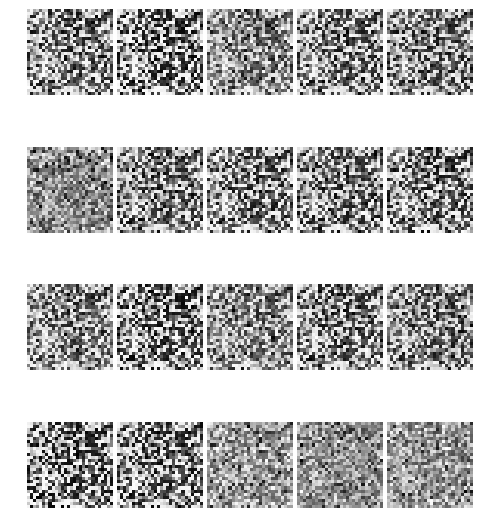

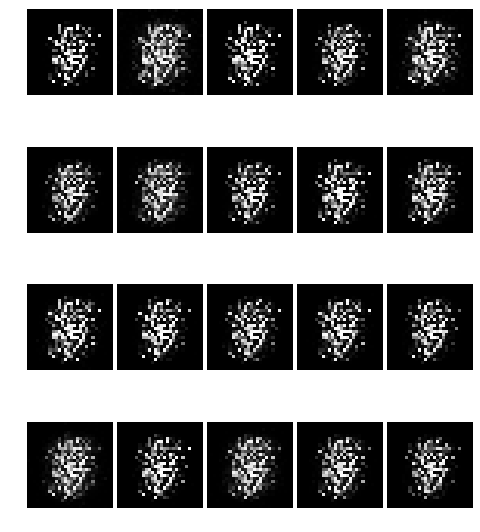

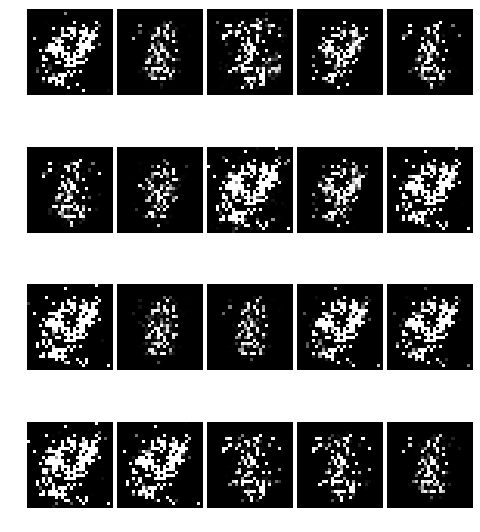

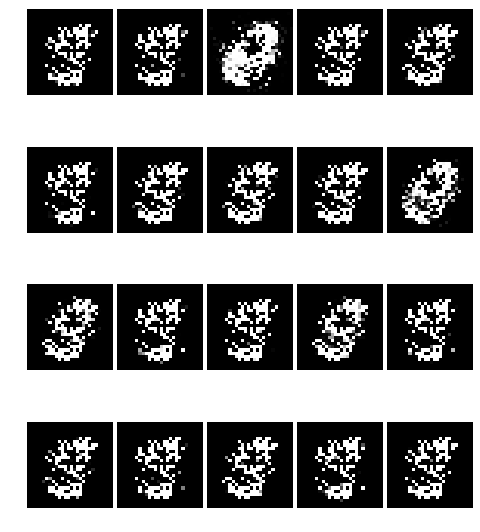

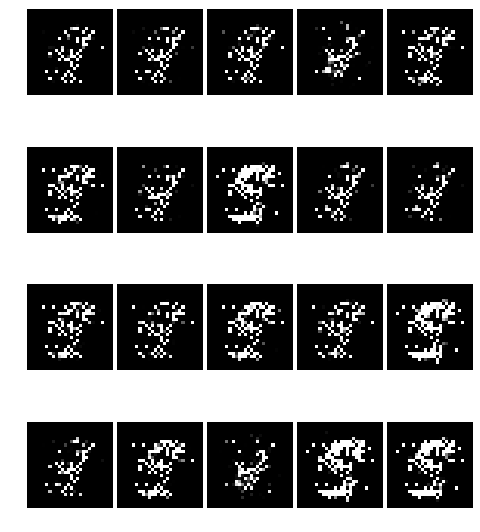

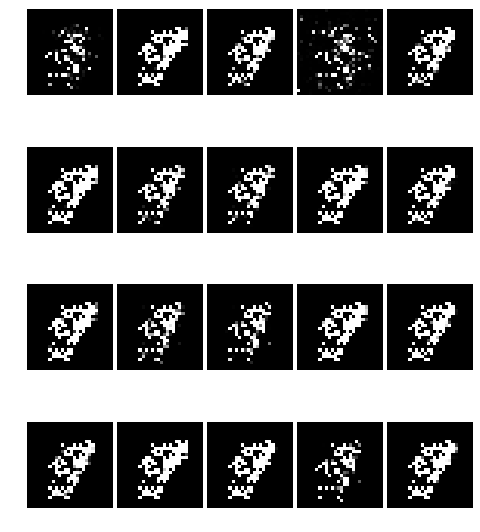

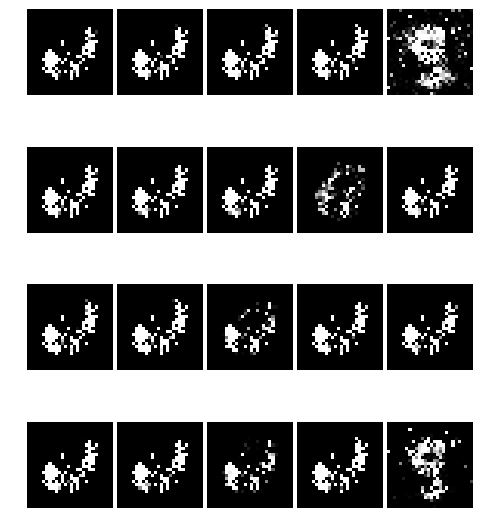

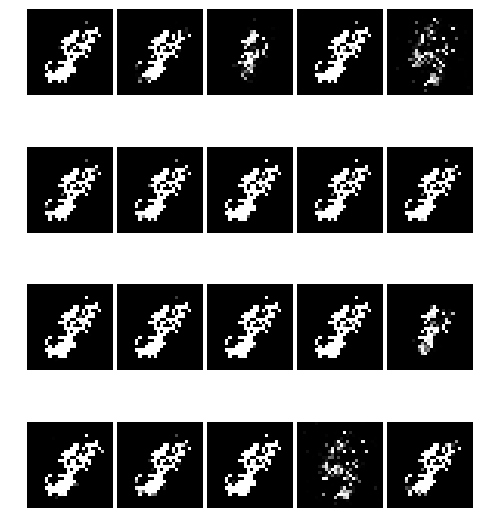

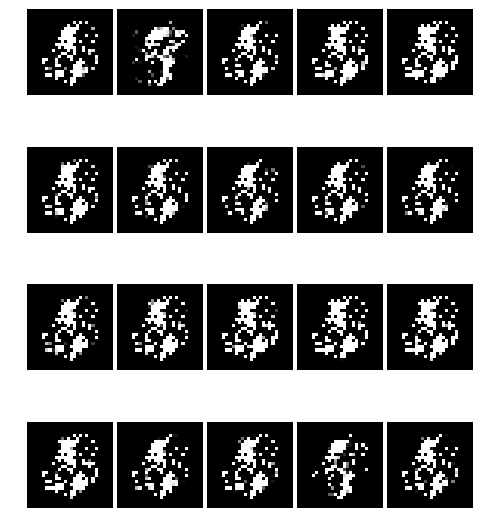

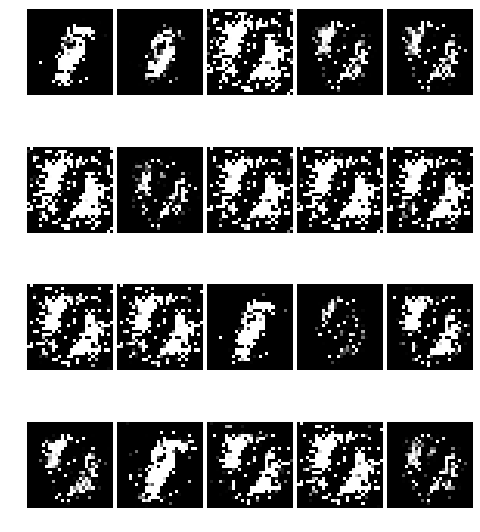

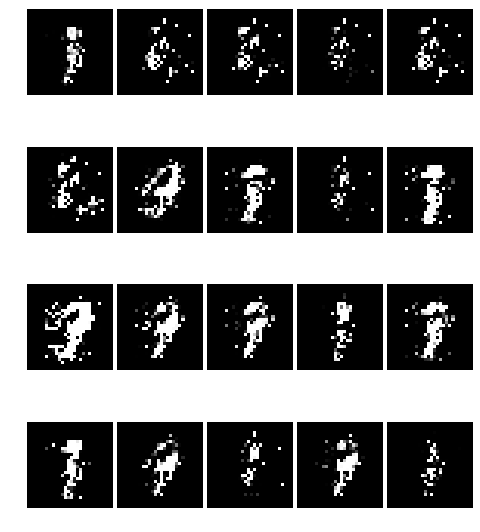

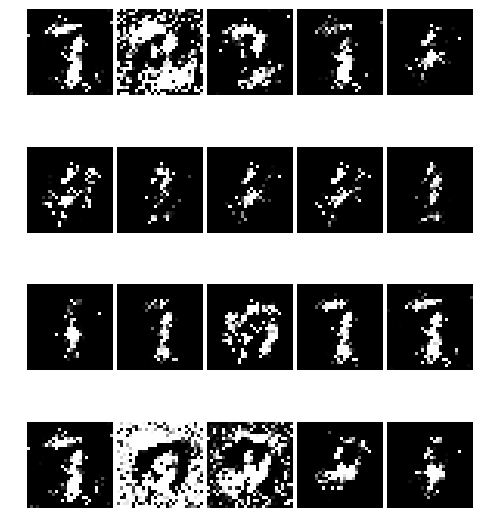

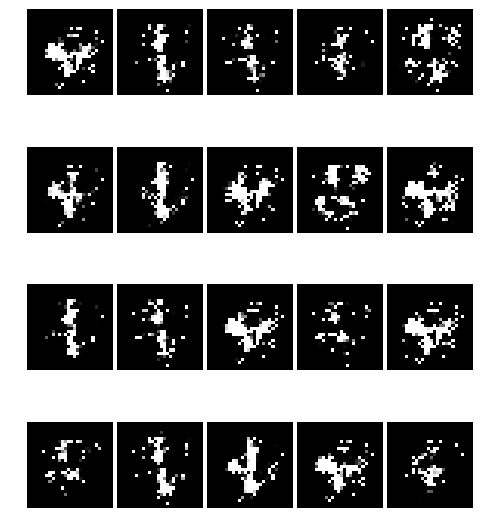

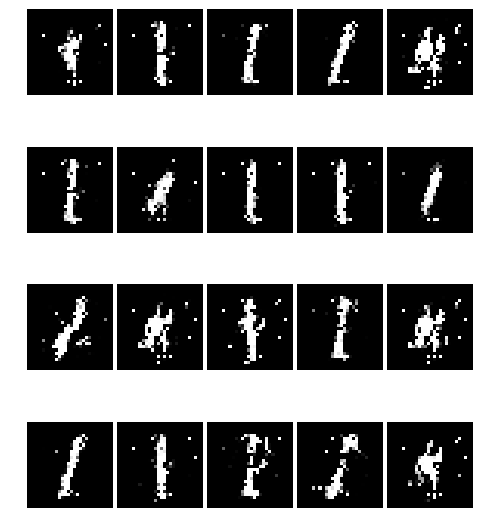

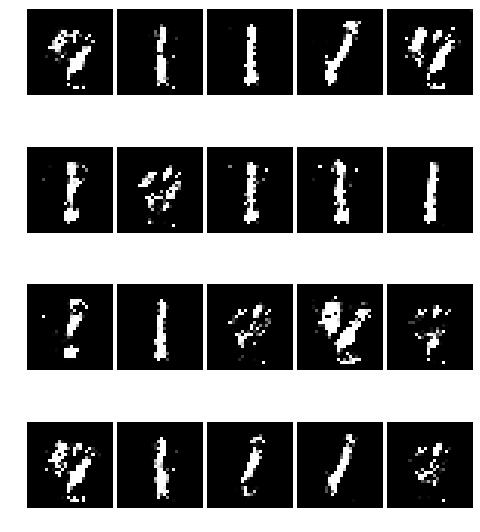

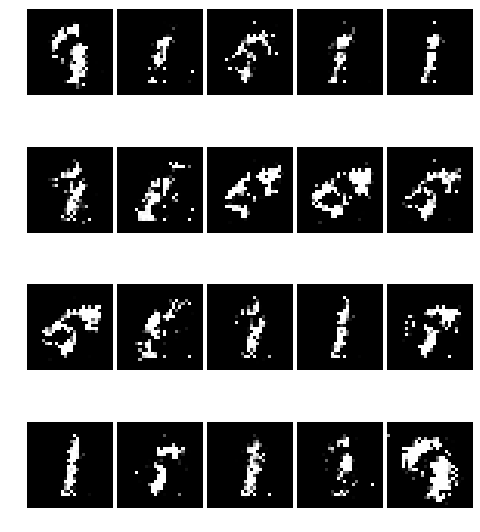

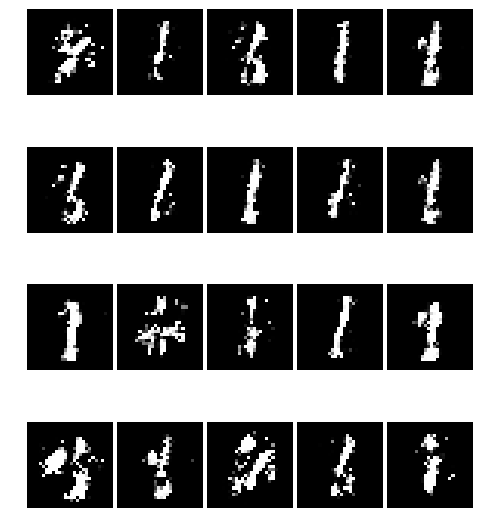

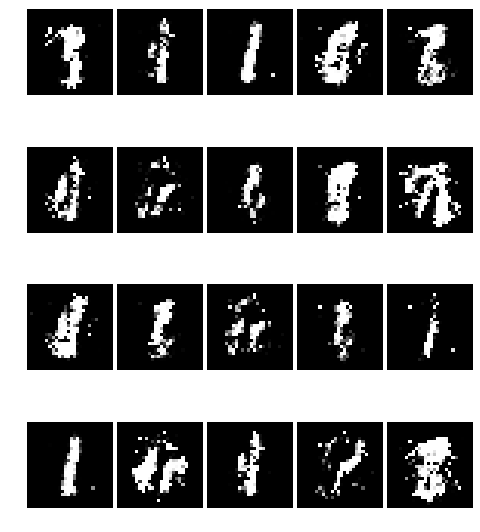

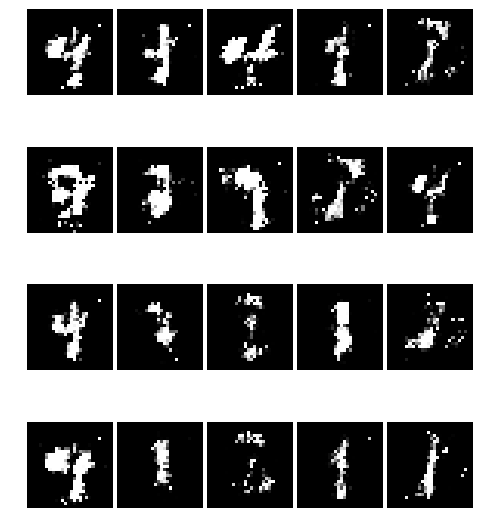

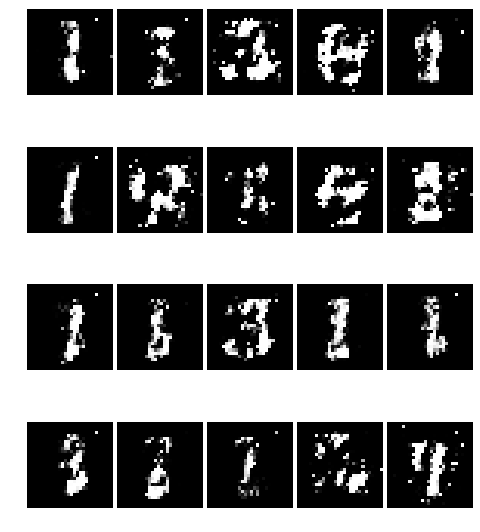

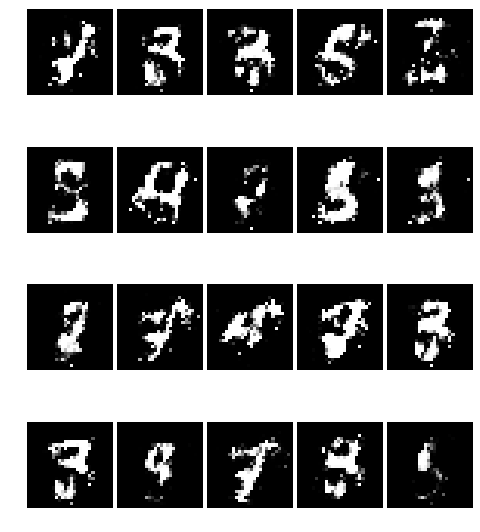

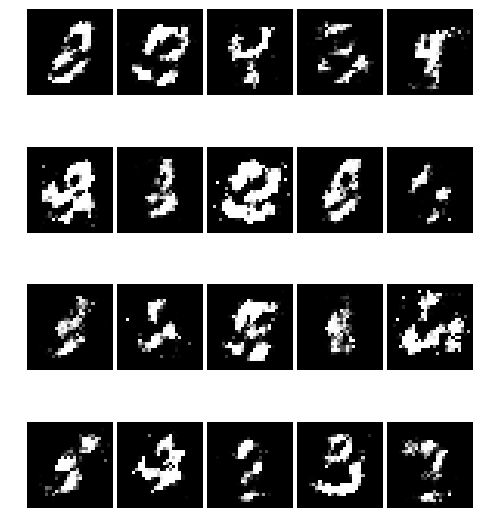

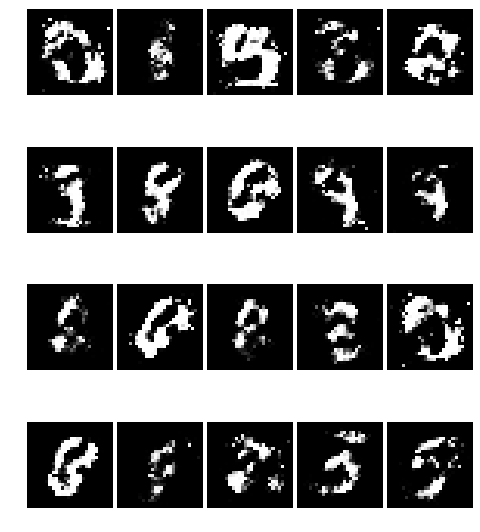

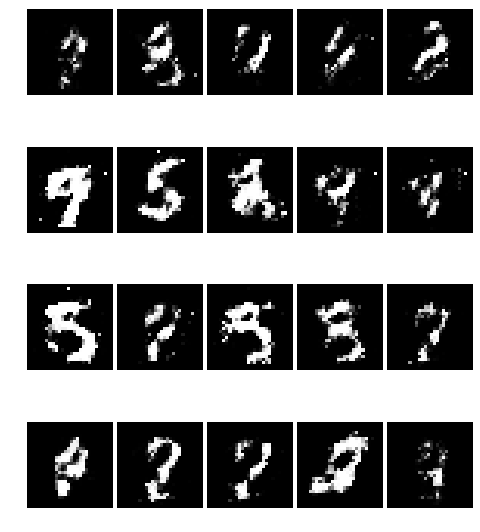

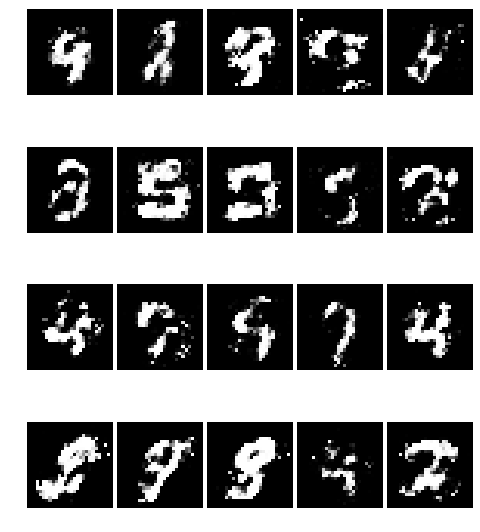

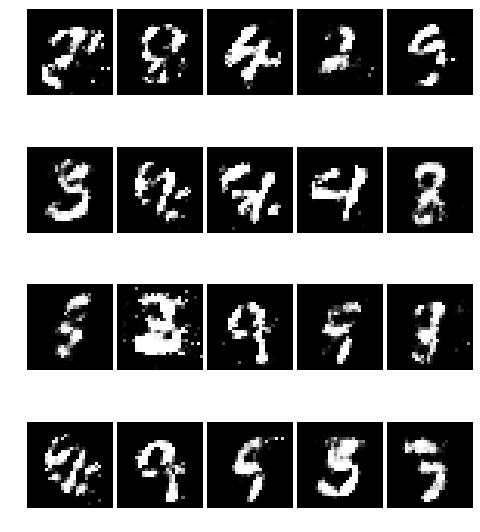

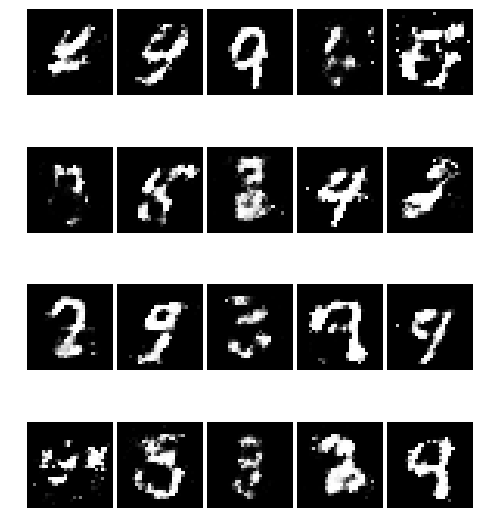

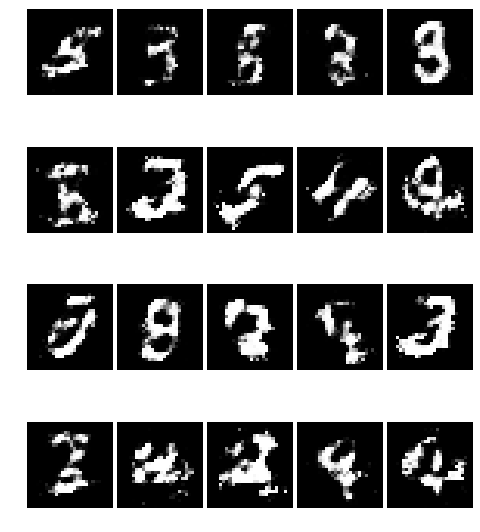

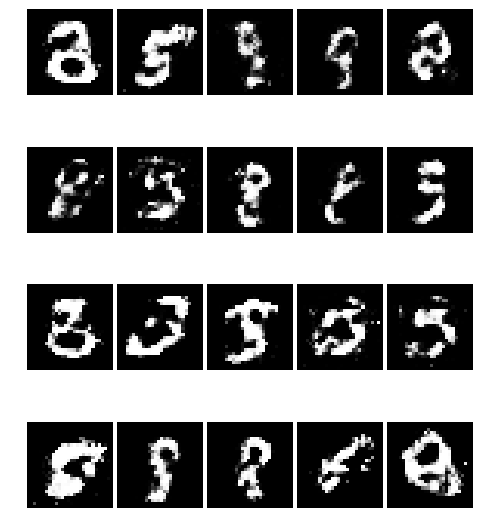

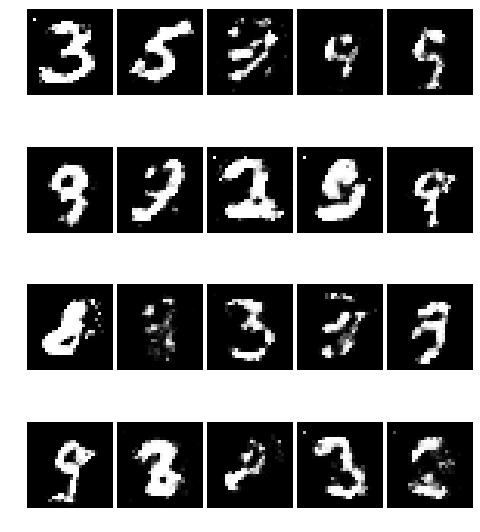

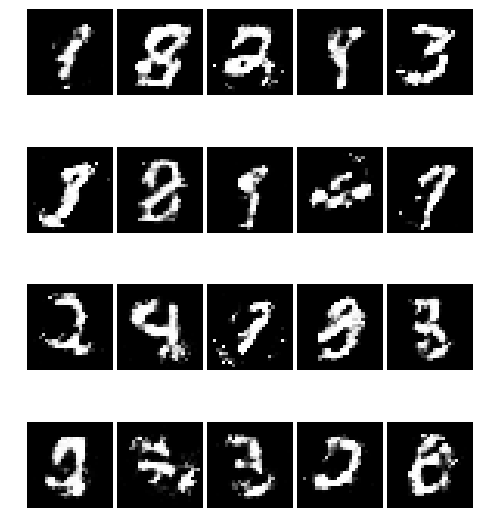

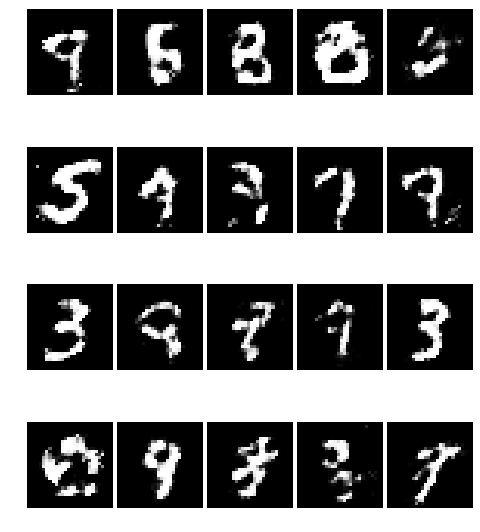

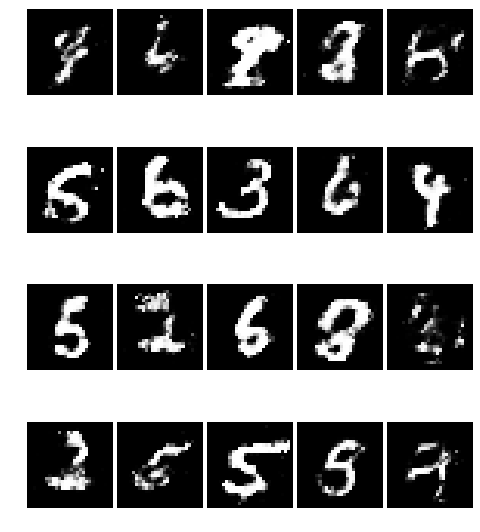

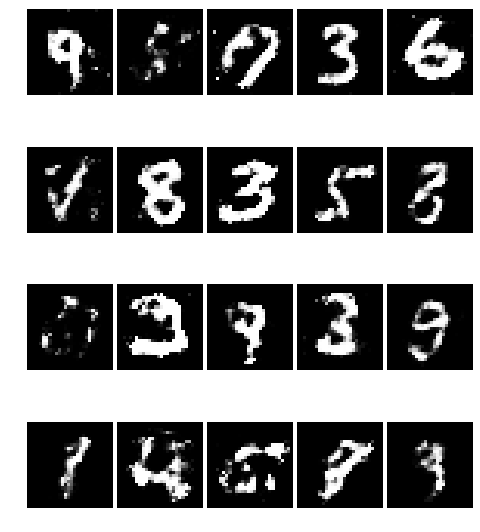

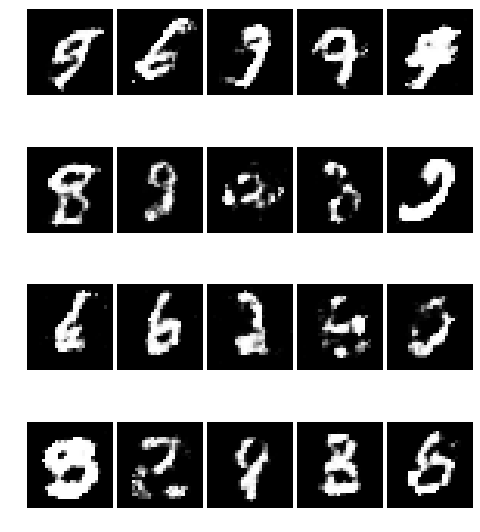

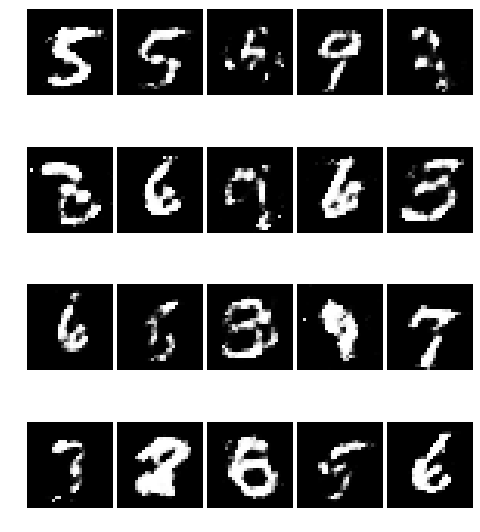

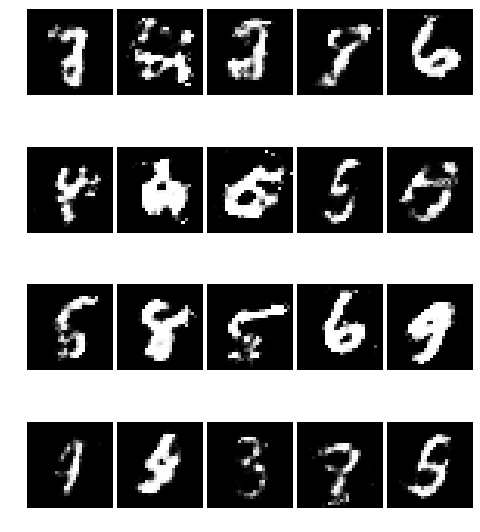

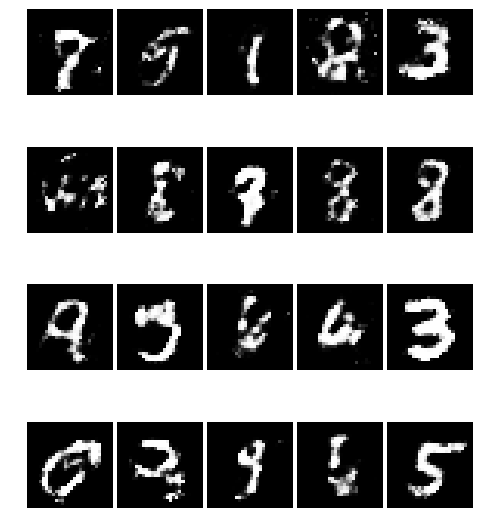

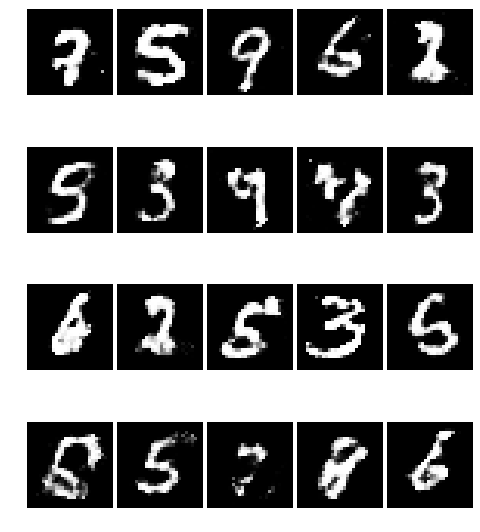

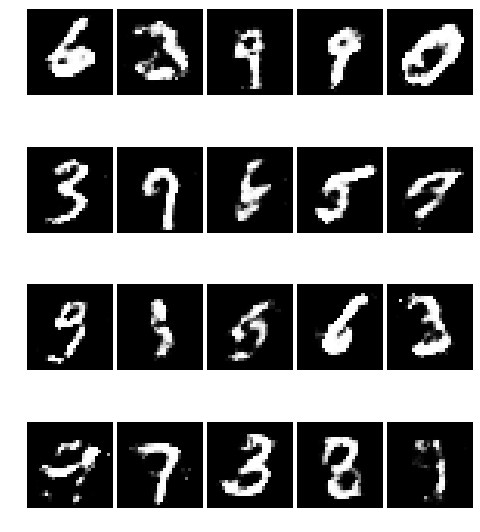

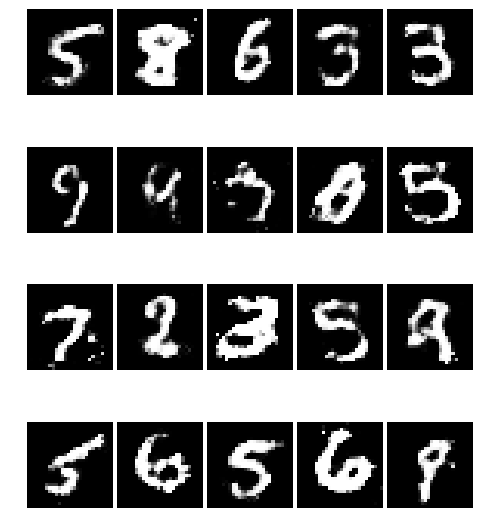

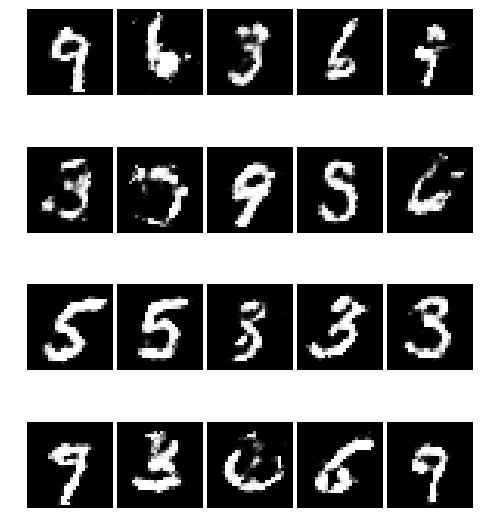

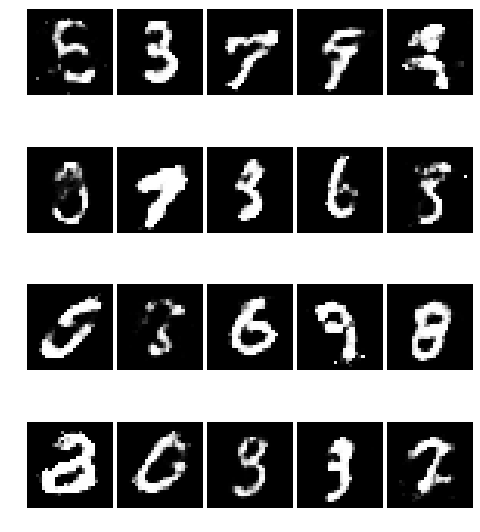

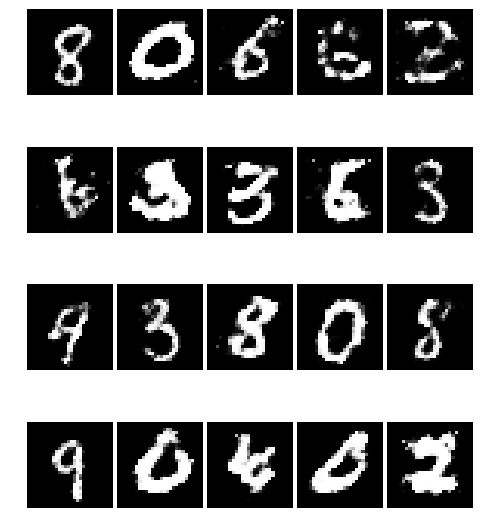

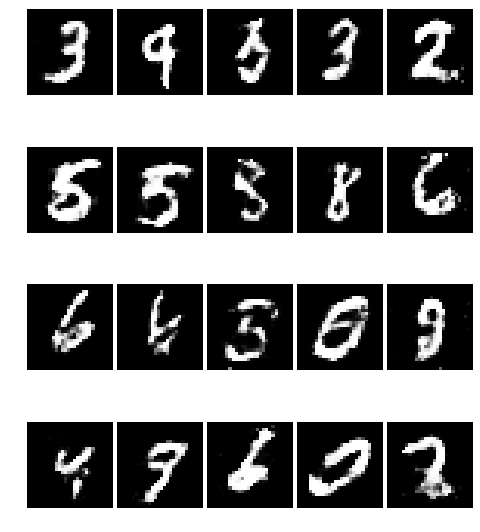

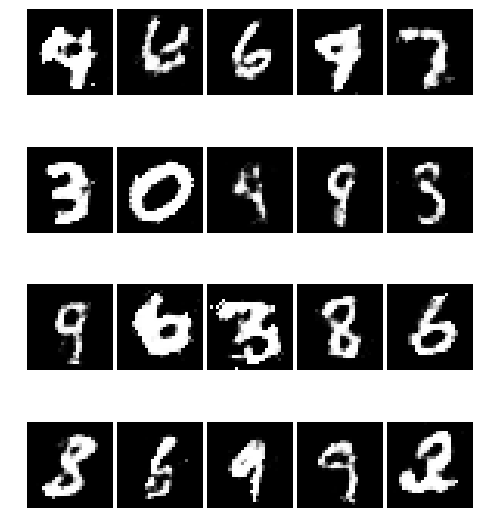

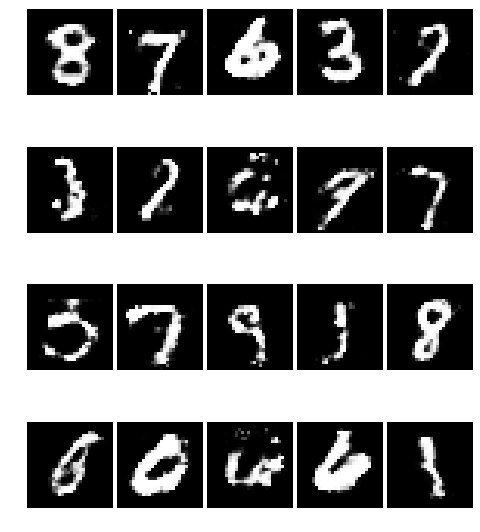

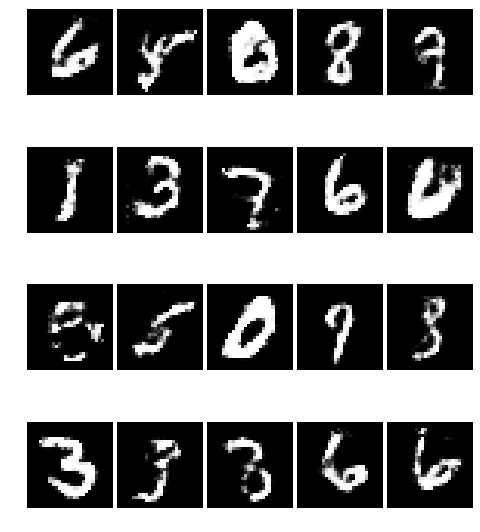

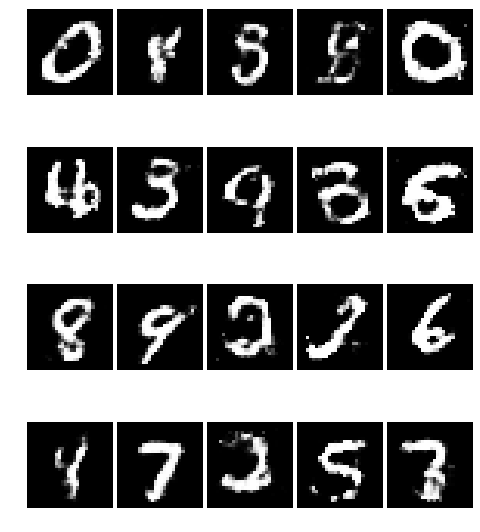

In [9]:
n_epochs=500
total_steps=len(mnist_dataloader)
generated_folder='generated_images/'
weights_model_folder='trained_folder/'

discriminator=Discriminator()
generator=Generator()

print("-----Discriminator-----")
print(discriminator,"\n")
print("-----Generator-----")
print(generator,"\n")

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

print("Training...")

for epoch in range(n_epochs):
    for index, (real_data_batch, _) in enumerate(mnist_dataloader):
        data_batch_size=real_data_batch.size(0)
        
        real_data_batch=V(real_data_batch.view(data_batch_size,784)) # Vectorize+ Variable
        real_data_batch=real_data_batch.cuda() # Cuda compatible
        
        false_data=generator(sample_noise(data_batch_size,100)).detach() # Generate false data...
        # but avoid discriminator gradients being updated by this
        
        dis_error, dis_prediction_real, dis_prediction_false=discriminator.train(real_data_batch, false_data) # Discriminator training
        
        false_data=generator(sample_noise(data_batch_size,100)) # Generate more false data
        gen_error=generator.train(discriminator, false_data) # Generator train
        
        if index%128==0: # Every minibatch
            print("\nEpoch {}, Batch {}\n".format(epoch,index))
            print("\tDiscriminator Error: {}, Generator Error: {}".format(dis_error,gen_error))
    
    if epoch%10==0: # Every 10 epochs
        generated_noise=sample_noise(20,100) # For generated image sample, noise vector
        generator_vec=generator(generated_noise) # Using the same generated noise vector
        sample_images=generator_vec.view(generator_vec.size(0),1,28,28).data
        
        fig=plt.figure(figsize=(8,10))
        gs=gridspec.GridSpec(4,5)
        gs.update(wspace=0.05, hspace=0.05)
        
        
        for i, sample_image in enumerate(sample_images):
            ax=plt.subplot(gs[i])
            plt.axis('off')
            plt.imshow(sample_image.cpu().reshape(28,28), cmap='Greys_r')
            
        if not os.path.exists(generated_folder):
            os.makedirs(generated_folder)
          
        figure_name="{}Epoch_{}.png".format(generated_folder, epoch)
        plt.savefig(figure_name, bbox_inches='tight')
        print("Saved {}".format(figure_name))
        
    if epoch%50==0:
        if not os.path.exists(weights_model_folder):
            os.makedirs(weights_model_folder)
        
        filepath_generator="{}generator_epoch{}".format(weights_model_folder, epoch)
        filepath_discriminator="{}discriminator_epoch{}".format(weights_model_folder, epoch)
        
        torch.save(generator, filepath_generator)
        torch.save(discriminator, filepath_discriminator)
        
        
plt.close(fig)